In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
import sklearn.metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from mixed_naive_bayes import MixedNB
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Importing the pre-processed version of the data and turning the target variable into a binary variable
df = pd.read_csv("preproc_data.csv")
df = df.iloc[:, 1:]
df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})
df.describe(include='all')

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalintlcalls,totalintlcharge,numbercustomerservicecalls
count,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.136287,0.457745,0.905696,0.739873,0.159757,0.505552,0.500827,0.498255,0.494973,0.500983,0.494609,0.331994,0.503846,0.304536
std,0.343129,0.181672,0.292282,0.438750,0.279362,0.166457,0.168083,0.167155,0.166495,0.165245,0.166795,0.214228,0.160508,0.241370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,1.000000,0.000000,0.000000,0.390718,0.387931,0.384615,0.381154,0.390203,0.384615,0.200000,0.397727,0.200000
50%,0.000000,0.458333,1.000000,1.000000,0.000000,0.503606,0.500000,0.504274,0.495865,0.501166,0.495726,0.300000,0.509091,0.200000
75%,0.000000,0.578704,1.000000,1.000000,0.333333,0.618140,0.612069,0.615385,0.605849,0.614878,0.606838,0.500000,0.613636,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Separating the dependent from the independent variables
X = df.drop('churn', axis=1).to_numpy()
y = df.loc[:, 'churn'].to_numpy()

In [4]:
# Apply undersampling to the imbalanced class

Xtrain, X_test, ytrain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array before: yes {count_yes}, no {count_no}")

# Apply RandomUnderSampler to address class imbalance
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(Xtrain, ytrain)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array after: yes {count_yes}, no {count_no}")

Array before: yes 519, no 3273
Array after: yes 519, no 3273


Now we will do a grid search over a set of parameters to find out what are the best hyperparameters for accuracy and for F1-Score.

In [5]:
params = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['auto', 'scale', 0.1, 1],
    'degree': [2, 3, 4],
    }

clf_accuracy = GridSearchCV(estimator=SVC(),param_grid=params,cv=5,n_jobs=5,verbose=1,scoring='accuracy')
clf_accuracy.fit(X_train,y_train)

print(clf_accuracy.best_params_)
svc_accuracy = SVC(**clf_accuracy.best_params_) 

f1 = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='micro')

clf_f1 = GridSearchCV(estimator=SVC(),param_grid=params,cv=5,n_jobs=5,verbose=1,scoring=f1)
clf_f1.fit(X_train,y_train)

print(clf_f1.best_params_)
svc_f1 = SVC(**clf_accuracy.best_params_) 

combi_svc = VotingClassifier(estimators=[('acc', svc_accuracy), ('f1', svc_f1)], voting='soft')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


The best hyperparameters ended up being the same for both the accuracy and F1 models. We will use cross validation to confirm one of the hyperparameters. In this case, we will check the C hyperparameter.

In [6]:
def cvSVMC(min, max, div, scoring):
    scorings = [0] * (max-min+1)
    list = [*range(min, max+1)]
    cValues = [x/div for x in list]
    j = 0
    for i in cValues:
        svm = SVC(kernel='rbf', C=i, gamma=1, degree=2)
        scores=cross_val_score(svm, X_train, y_train, cv=10, scoring=scoring)

        scorings[j] = scores.mean()
        j+=1

    plt.scatter(cValues, scorings)

    plt.xlabel('C')
    plt.ylabel(scoring)

    plt.title(f'Relation between hyperparameter C and {scoring} for RBF Kernel')
    plt.show()


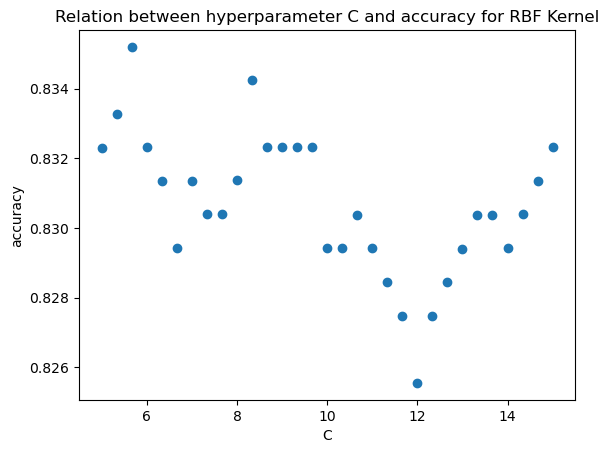

In [7]:
cvSVMC(min=15, max=45, div=3, scoring='accuracy')



We can see that the values have very low variance, and there seems to be a drop from C=9.5 to 10, and then the values decrease until C=12. This might indicate that the there is some overfitting for smaller values of C, and underfitting for bigger values.


Next, we will evaluate the final model.

In [8]:
def evaluate(model):
    predictions = model.predict(X_test)

    cm = metrics.confusion_matrix(y_test, predictions)

    #ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    #plt.show()

    print(cm)

    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    total = tp + tn + fp + fn
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print(f"SVM:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print(f"Accuracy: {(tp+tn)/total}")
    print(f"Error: {1-(tp+tn)/total}")
    print(f"Recall: {recall}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"F1: {2*recall*precision/(recall+precision)}")

In [9]:
#Best Results for Acc and F1: Kernel = RBF, C = 10, Gamma = 1, Degree = 2

svm = SVC(kernel='rbf', C=10, gamma=1, degree=2)
svm.fit(Xtrain, ytrain)
evaluate(svm)

[[804  17]
 [ 53  74]]
SVM:
TP: 74, TN: 804, FP: 17, FN: 53
Accuracy: 0.9261603375527426
Error: 0.07383966244725737
Recall: 0.5826771653543307
Specificity: 0.9792935444579781
Precision: 0.8131868131868132
F1: 0.6788990825688073


Overall, the SVM has a high accuracy, but a disappointing F1-Score. This may mean that the SVM did not do a good job dealing with unbalanced classes.